In [48]:
import sklearn_crfsuite
import eli5
from load_data import load_data
from sklearn.model_selection import train_test_split
from SL_config import *

def word2features(doc, i):
    # TODO: add quote information
    w = doc[i][0]
    word = w.text
    pos_ = w.pos_
    tag_ = w.tag_
    lemma_ = w.lemma_
    dep_ = w.dep_
    shape_ = w.shape_
    is_stop = w.is_stop
    is_alpha = w.is_alpha
    head_text =  w.head.text
    head_pos = w.head.pos_
    head_tag = w.head.tag_

    # Common features for all words
    features = [
        'bias',
        'word.lower=' + word.lower(),
        # 'word[-3:]=' + word[-3:],
        # 'word[-2:]=' + word[-2:],
        'word.isupper=%s' % word.isupper(),
        'word.istitle=%s' % word.istitle(),
        'word.isdigit=%s' % word.isdigit(),
        'pos_=' + pos_,
        'tag_=' + tag_,
        'dep_=' + dep_,
        # 'shape_=' + shape_,
        'lemma_=' + lemma_,
        'head_text=' + head_text,
        'head_pos=' + head_pos,
        'head_tag=' + head_tag,

    ]



    for step in range(1, 1+FEAT_CTX_SIZE):
        # Features for words that are not
        # at the beginning of a document
        if i-step > 0:
            w1 = doc[i-step][0]
            word1 = w1.text
            pos_1 = w1.pos_
            tag_1 = w1.tag_
            lemma_1 = w1.lemma_
            dep_1 = w1.dep_
            # shape_1 = w1.shape_
            # is_stop1 = w1.is_stop
            # is_alpha1 = w1.is_alpha
            head_text1 = w1.head.text
            head_pos1 = w1.head.pos_
            head_tag1 = w1.head.tag_
            features.extend([
                '-%s:word.lower=' % step + word1.lower(),
                '-%s:word.istitle=%s' % (step, word1.istitle()),
                '-%s:word.isupper=%s' % (step, word1.isupper()),
                '-%s:word.isdigit=%s' % (step, word1.isdigit()),
                '-%s:pos_='% step + pos_1,
                '-%s:tag_='% step + tag_1,
                '-%s:lemma_='% step + lemma_1,
                '-%s:dep_='% step + dep_1,
                # '-%s:shape_='% step + shape_1,
                # '-%s:is_stop=%s' % (step, is_stop1),
                # '-%s:is_alpha=%s' % (step, is_alpha1),
                '-%s:head.text='% step + head_text1,
                '-%s:head.pos_='% step + head_pos1,
                # '-%s:head_tag_='% step + head_tag1,
            ])
        else:
            # Indicate that it is the 'beginning of a document'
            features.append('BOS')

        # Features for words that are not
        # at the end of a document
        if i+step < len(doc)-1:
            w1 = doc[i+step+1][0]
            word1 = w1.text
            pos_1 = w1.pos_
            tag_1 = w1.tag_
            lemma_1 = w1.lemma_
            dep_1 = w1.dep_
            shape_1 = w1.shape_
            # is_stop1 = w1.is_stop
            # is_alpha1 = w1.is_alpha
            head_text1 = w1.head.text
            head_pos1 = w1.head.pos_
            head_tag1 = w1.head.tag_
            features.extend([
                '+%s:word.lower=' % step + word1.lower(),
                '+%s:word.istitle=%s' % (step ,word1.istitle()),
                '+%s:word.isupper=%s' % (step, word1.isupper()),
                '+%s:word.isdigit=%s' % (step, word1.isdigit()),
                 '+%s:pos_=%s' % (step, pos_1),
                '+%s:tag_=%s' % (step, tag_1),
                '+%s:lemma_=%s' % (step, lemma_1),
                '+%s:dep_=%s' % (step, dep_1),
                # '+%s:shape_=%s' % (step, shape_1),
                # '+%s:shape_=%s' % (step, shape_1),
                # '+%s:is_stop=%s' % (step, is_stop1),
                # '+%s:is_alpha=%s' % (step, is_alpha1),
                '+%s:head.text=%s' % (step, head_text1),
                '+%s:head.pos_=%s' % (step, head_pos1),
                # '+%s:head_tag_=%s' % (step, head_tag1),
            ])
        else:
            # Indicate that it is the 'end of a document'
            features.append('EOS')

    return features


# A function for extracting features in documents
def extract_features(doc):
    return [word2features(doc, i) for i in range(len(doc))]

# A function fo generating the list of labels for each document
def get_labels(doc):
    return [tok[-1] for tok in doc]

def get_tokens(doc):
    return [tok[0].text for tok in doc]

def split_train_test_set():
    pos_data, neg_data = load_data()
    print("Starting to generate features ...")
    pos_X = [extract_features(pos_sent) for pos_sent in pos_data]
    pos_y = [get_labels(doc) for doc in pos_data]
    neg_X = [extract_features(neg_sent) for neg_sent in neg_data]
    neg_y = [get_labels(neg_y) for neg_y in neg_data]


    pos_X_train, pos_X_test, pos_y_train, pos_y_test = train_test_split(
        pos_X, pos_y, test_size=TEST_SET_FRAC, random_state=SEED, shuffle=True)
    neg_X_train, neg_X_test, neg_y_train, neg_y_test = train_test_split(
        neg_X, neg_y, test_size=TEST_SET_FRAC, random_state=SEED, shuffle=True)

    # X_train = pos_X_train
    # y_train = pos_y_train

    X_train = pos_X_train + neg_X_train
    y_train = pos_y_train + neg_y_train

    X_test = pos_X_test + neg_X_test
    y_test = pos_y_test + neg_y_test

    return (X_train, y_train), (X_test, y_test)


In [49]:
(X_train, y_train), (X_test, y_test) = split_train_test_set()

Starting to generate features ...


In [50]:
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=2.35,
    c2=0.008,
    max_iterations=1000,
    all_possible_transitions=False,
)
crf.fit(X_train, y_train);

In [51]:
eli5.show_weights(crf, top=30)
# eli5.show_weights(crf)

In [52]:
from sklearn_crfsuite import metrics

labels = list(crf.classes_)
y_pred = crf.predict(X_test)
metrics.flat_f1_score(y_test, y_pred, 
                      average='weighted', labels=labels)

sorted_labels = sorted(
    labels, 
    key=lambda name: (name[1:], name[0])
)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

             precision    recall  f1-score   support

          I      0.707     0.530     0.606       219
          O      0.991     0.996     0.993     11545

avg / total      0.986     0.987     0.986     11764



| c1        | c2           | precision  | recall | f1-score | support| CTX
| ------------- |:-------:| -----:|-----|-----|-----|---
| 2      | 0.1 | 0.737 |0.511|0.598    |   219 | 3
|1.8| .008 |0.730   |  0.507 |    0.598  |     219 | 3
| 2      | 0.08 | 0.737 |0.511|0.604     |   219 | 3
| 2.1      | 0.08 | 0.737 |0.511|0.604     |   219 | 3
| 2.2     | 0.08 | 0.739 |0.516|0.608     |   219 | 3
| 2.3     | 0.08 | 0.739 |0.516|0.608     |   219 | 3
| 2.35     | 0.08 | 0.740 |0.521 |0.611    |   219 | 3
| 2.4     | 0.08 | 0.734 |0.516|0.606     |   219 | 3

In [6]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
import scipy.stats

In [7]:
import warnings
warnings.filterwarnings('always')

In [8]:

%%time
# define fixed parameters and parameters to search
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    max_iterations=100,
    all_possible_transitions=True
)
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
}

# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='weighted', labels=labels)

# search
rs = RandomizedSearchCV(crf, params_space,
                        cv=3,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=50,
                        scoring=f1_scorer)
rs.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   30.0s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  2.1min finished


CPU times: user 57.5 s, sys: 5.61 s, total: 1min 3s
Wall time: 2min 7s


In [9]:
# crf = rs.best_estimator_
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

best params: {'c1': 2.3342661514360277, 'c2': 0.008051137430478235}
best CV score: 0.9772759245435024
model size: 0.03M


/Users/yekun/Documents/ENV/anaconda3/envs/mlp/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/Users/yekun/Documents/ENV/anaconda3/envs/mlp/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/Users/yekun/Documents/ENV/anaconda3/envs/mlp/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


Dark blue => 0.9739, dark red => 0.9773


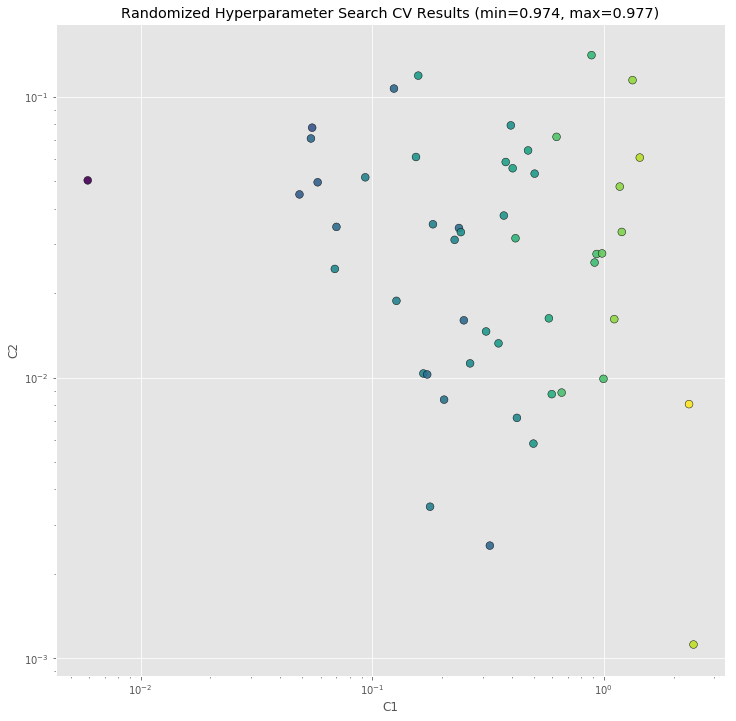

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
_x = [s.parameters['c1'] for s in rs.grid_scores_]
_y = [s.parameters['c2'] for s in rs.grid_scores_]
_c = [s.mean_validation_score for s in rs.grid_scores_]

fig = plt.figure()
fig.set_size_inches(12, 12)
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_title("Randomized Hyperparameter Search CV Results (min={:0.3}, max={:0.3})".format(
    min(_c), max(_c)
))

ax.scatter(_x, _y, c=_c, s=60, alpha=0.9, edgecolors=[0,0,0])

print("Dark blue => {:0.4}, dark red => {:0.4}".format(min(_c), max(_c)))

In [15]:
rs.cv_results_

/Users/yekun/Documents/ENV/anaconda3/envs/mlp/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/yekun/Documents/ENV/anaconda3/envs/mlp/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/yekun/Documents/ENV/anaconda3/envs/mlp/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  war

{'mean_fit_time': array([4.08747323, 4.83965166, 4.81049959, 4.7768569 , 4.8061614 ,
        4.9535017 , 4.77530821, 4.91820836, 4.8230861 , 4.96909436,
        4.41495967, 4.03464357, 4.60785492, 4.88794764, 4.89499553,
        5.2434237 , 4.8326544 , 4.76079504, 4.85389487, 4.91505003,
        4.74463097, 4.83593957, 5.18757709, 5.00150053, 4.87325501,
        4.87387506, 4.75722488, 5.14313499, 4.79363267, 4.98989336,
        4.86247571, 4.77615333, 5.05687793, 5.72370068, 4.98825161,
        4.92319965, 5.10086942, 5.40954963, 5.38573464, 5.43530766,
        5.59104641, 5.58094652, 5.78954061, 5.49189639, 5.3817997 ,
        5.00636808, 4.73045834, 4.86947997, 4.77520911, 3.86012236]),
 'std_fit_time': array([0.33564246, 0.08410857, 0.05093314, 0.2134736 , 0.10588331,
        0.36239264, 0.23765013, 0.35441782, 0.14591989, 0.02407325,
        0.34733226, 0.21707428, 0.22411737, 0.11218801, 0.16894159,
        0.33357109, 0.15790229, 0.20358885, 0.11750091, 0.122852  ,
        0.166

In [19]:
# crf = rs.best_estimator_
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

best params: {'c1': 2.3342661514360277, 'c2': 0.008051137430478235}
best CV score: 0.9772759245435024
model size: 0.03M
